# Clustering Unlabeled Sound Data

This project focuses on clustering unlabeled sound data using dimensionality reduction techniques (PCA & t-SNE) and clustering algorithms (K-Means & DBSCAN). The goal is to explore high-dimensional data, extract meaningful features, and determine the most effective clustering method.

In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score

In [ ]:
# mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the Data
unlabelled_data_path = '/content/drive/MyDrive/2025/Machine Learning Projects/unlabelled_sounds'

# Get list of all .wav files in the directory
your_file_list = [os.path.join(unlabelled_data_path, f) for f in os.listdir(unlabelled_data_path) if f.endswith(".wav")]

# Print number of samples in the dataset
print("The number of sumples are:", len(your_file_list))

The number of sumples are: 3000


In [ ]:

features = []
#Extract Features

def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return np.mean(mel_spec_db, axis=1)

# Apply feature extraction to all files
for file in your_file_list:
    features.append(extract_features(file))

features_array = np.array(features)



/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1705
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1837
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1915
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1710
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1932
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1538
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py

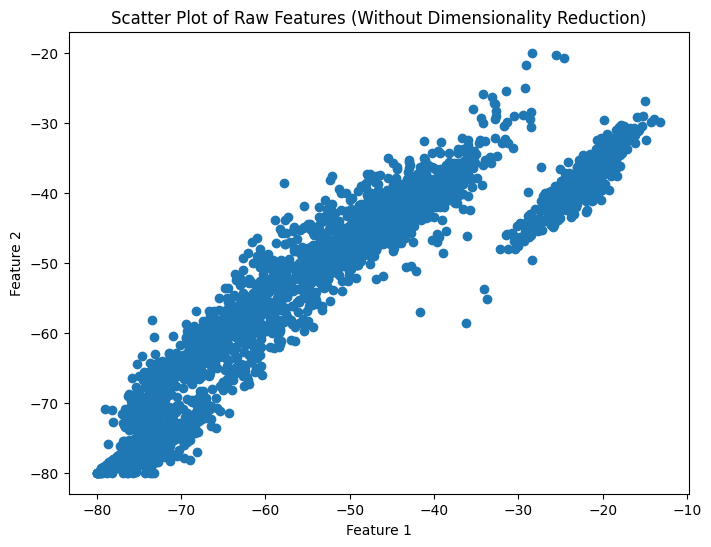

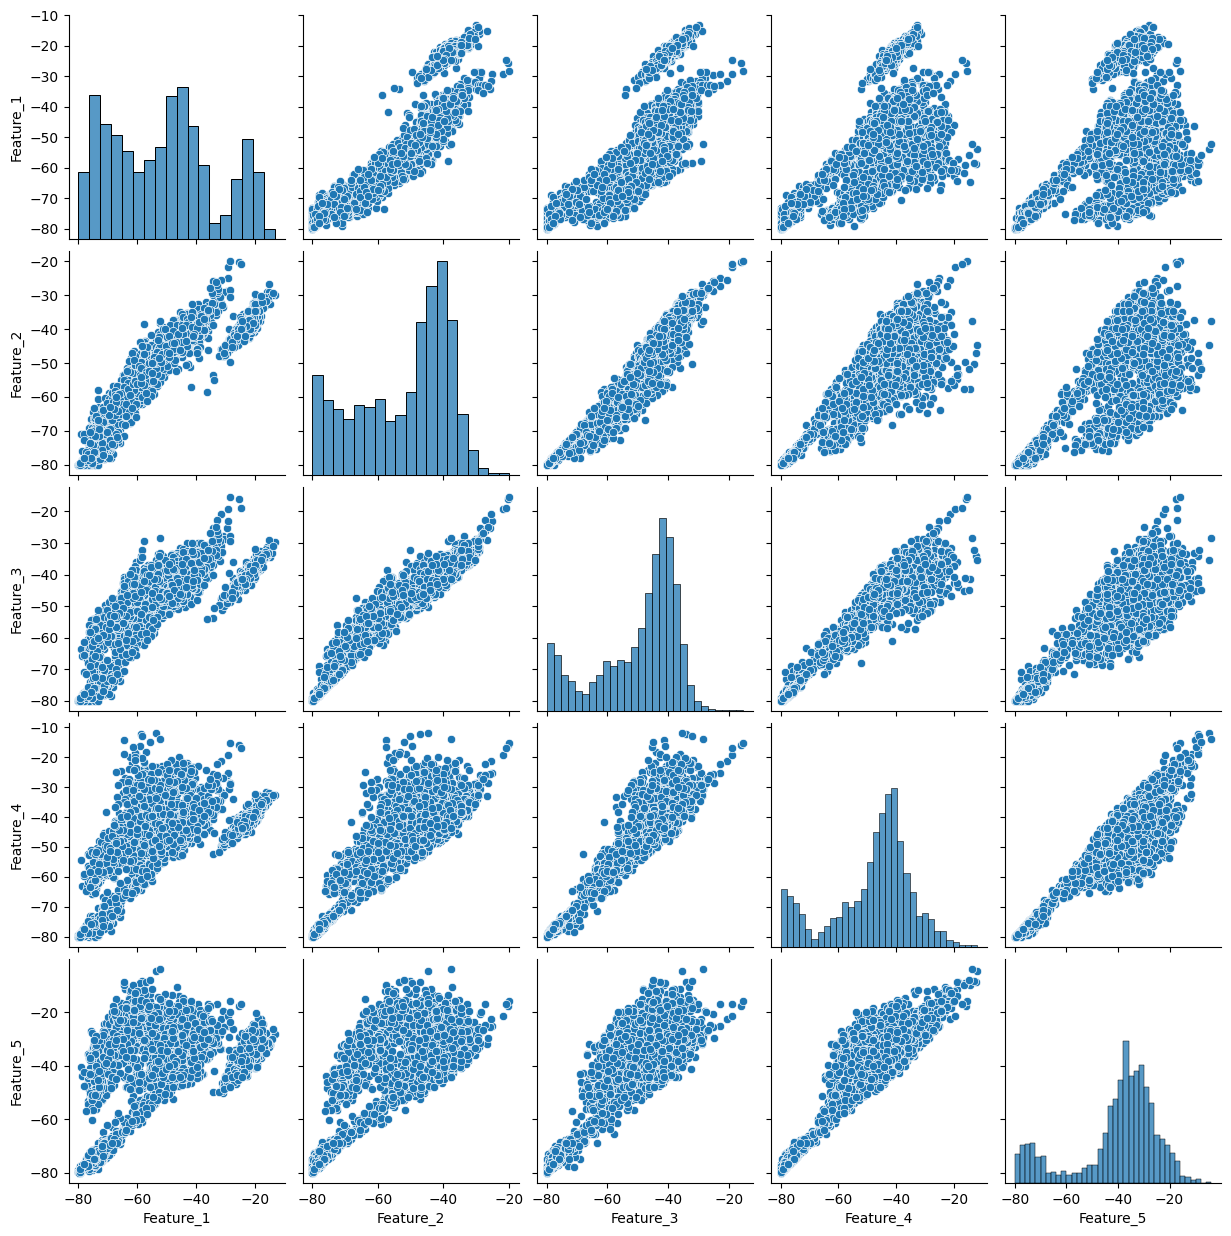

In [ ]:

# Scatter plot (Attempt without dimensionality reduction)
plt.figure(figsize=(8,6))
plt.scatter(features_array[:, 0], features_array[:, 1])
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Scatter Plot of Raw Features (Without Dimensionality Reduction)")
plt.show()

# Pair plot (Using first 5 features)
df = pd.DataFrame(features_array[:, :5], columns=[f'Feature_{i+1}' for i in range(5)])
sns.pairplot(df)
plt.show()


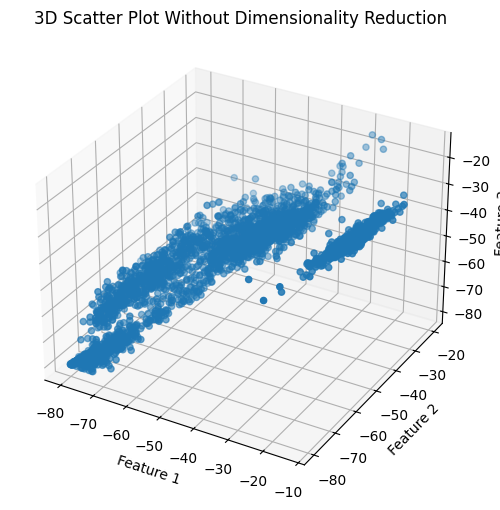

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(features_array[:, 0], features_array[:, 1], features_array[:, 2])

ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_zlabel("Feature 3")
ax.set_title("3D Scatter Plot Without Dimensionality Reduction")
plt.show()

### Dimensionality Reduction

### Observation from the Plots Above
-------
Before I answer why dimensionality reduction is important, let me first say my observations when trying to visualize the data without dimension reduction. Clearly you can see the dataset has many features but when you try to display them in two dimensions You can see they will be overlapping clusters this would create difficulty in differentiate in 2D dimension I even tried 3D though there was an improvement the result was still not good.

--------
### Why is dimensionality reduction important?


*   Avoiding Clusters Overlap, this is due to retaining a small number dimensions while also perserving the variance of the data, this is done through PCA.

*   Noise Reduction, as some features may contain noise meaning unuseful information for the analysis reducing the dimension would help to remove irrelevant dimensions.

*  Performance Improvement, training models requires a high computational cost but with reducing the dimensions we would reduce the cost hence high performance.


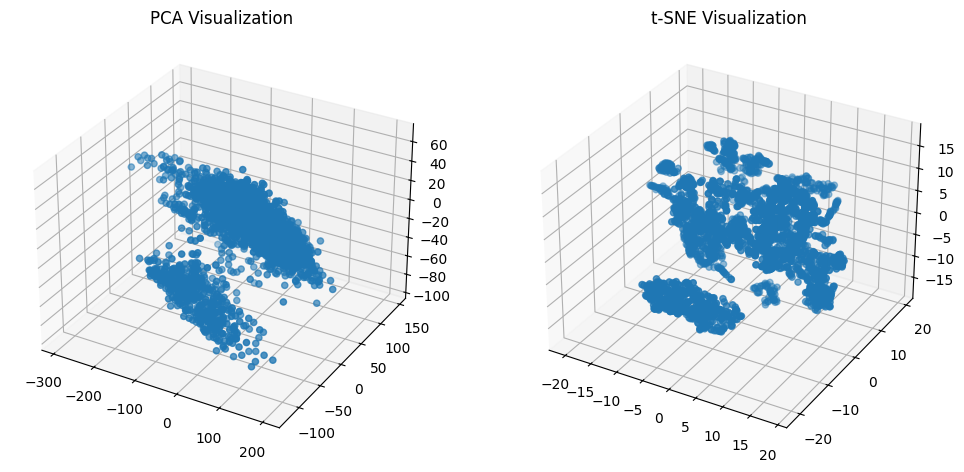

In [ ]:


pca = PCA(n_components=3)
features_pca = pca.fit_transform(features_array)

tsne = TSNE(n_components=3, perplexity=30, random_state=42)
features_tsne = tsne.fit_transform(features_array)

# 3D Visualization
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(features_pca[:, 0], features_pca[:, 1], features_pca[:, 2])
ax.set_title("PCA Visualization")

ax = fig.add_subplot(122, projection='3d')
ax.scatter(features_tsne[:, 0], features_tsne[:, 1], features_tsne[:, 2])
ax.set_title("t-SNE Visualization")
plt.show()



### Which method (PCA or t-SNE) provides better separability of clusters and why?

From the observation t-SNE provides better separation of clusters because PCA shows a more continuous distribution of the data you can see PCA is a linear dimensionality reduction technique which may not be effective on capturing non-linear patterns this have a challenge on separating clusters clearly by focusing on maximizing variance along principal components. While t-SNE provides a better separation of clusters because it is a non-linear dimensionality reduction techniques it also focuses on preserving local relationship between points hence presenting more distinct clusters.


### Clustering

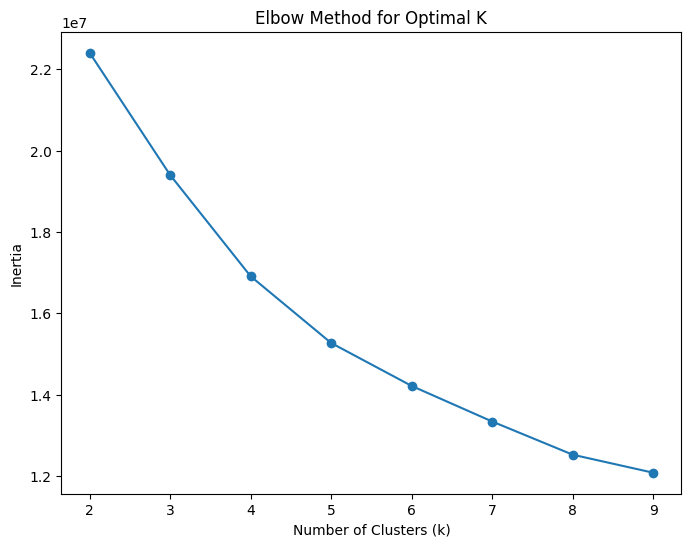

In [ ]:


# Optimize number of clusters using Elbow Method
inertia = []
k_values = range(2, 10)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_array)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,6))
plt.plot(k_values, inertia, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.show()



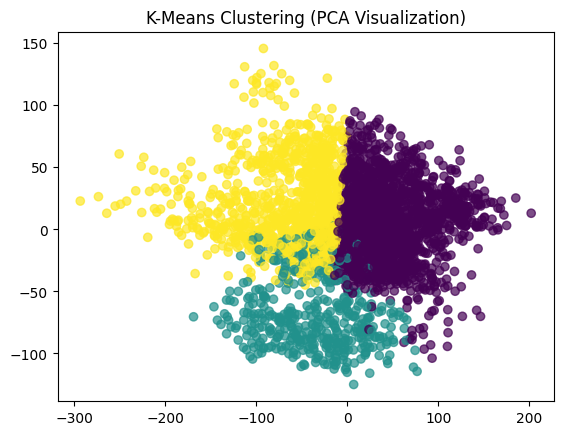

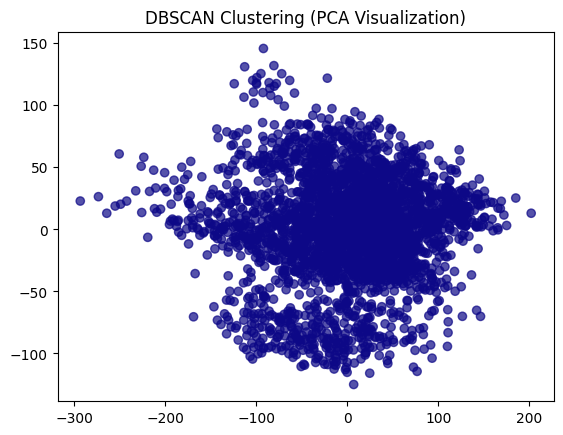

In [ ]:

# Select optimal K
optimal_k = 3  # Adjust based on elbow method
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(features_array)

# Apply DBSCAN
dbscan = DBSCAN(eps=5, min_samples=3)
dbscan_labels = dbscan.fit_predict(features_array)

# Scatter Plot for K-Means Clusters
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.title("K-Means Clustering (PCA Visualization)")
plt.show()

# Scatter Plot for DBSCAN Clusters
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=dbscan_labels, cmap='plasma', alpha=0.7)
plt.title("DBSCAN Clustering (PCA Visualization)")
plt.show()



In [ ]:

# Evaluate clustering
kmeans_silhouette = silhouette_score(features_array, kmeans_labels)
kmeans_db_index = davies_bouldin_score(features_array, kmeans_labels)

if len(set(dbscan_labels)) > 1:
    dbscan_silhouette = silhouette_score(features_array, dbscan_labels)
    dbscan_db_index = davies_bouldin_score(features_array, dbscan_labels)
else:
    dbscan_silhouette = None
    dbscan_db_index = None

print(f"K-Means - Silhouette Score: {kmeans_silhouette:.4f}, Davies-Bouldin Index: {kmeans_db_index:.4f}")
if dbscan_silhouette is not None:
    print(f"DBSCAN - Silhouette Score: {dbscan_silhouette:.4f}, Davies-Bouldin Index: {dbscan_db_index:.4f}")
else:
    print("DBSCAN failed to form meaningful clusters.")


K-Means - Silhouette Score: 0.2521, Davies-Bouldin Index: 1.4325
DBSCAN failed to form meaningful clusters.


### Discuss the results (max 5 lines)

K-Means is performing better as it achieved a Silhouette Score of 0.2521 and a Davies-Bouldin Index of 1.4325 which shows a moderate cluster separation and compactness while DBSCAN failed to form meaningful clusters maybe due to the density distribution of data.

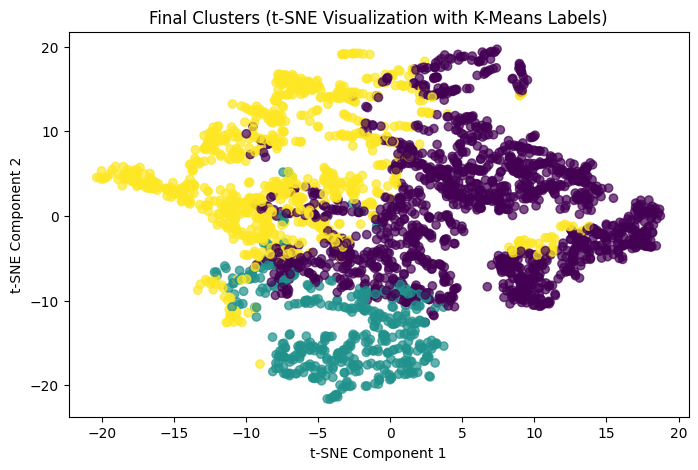

In [ ]:

# Final Visualization using t-SNE
plt.figure(figsize=(8, 5))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Final Clusters (t-SNE Visualization with K-Means Labels)")
plt.show()


### Final Analysis

Without dimensionality reduction, visualizing high-dimensional data leads to overlapping clusters, making separation difficult. PCA helps by preserving variance while reducing dimensions, avoiding overlap, reducing noise, and improving computational efficiency.

Among clustering methods, t-SNE provided better cluster separation than PCA due to its ability to capture non-linear patterns and preserve local relationships. K-Means performed better with a Silhouette Score of 0.2521 and Davies-Bouldin Index of 1.4325, indicating moderate clustering effectiveness. DBSCAN failed to form meaningful clusters, likely due to the density distribution not being suitable.

#### *Relating to Real-World Clustering Challenges*

Clustering high-dimensional data is challenging because overlapping features reduce the effectiveness of distance-based cluster methods. Choosing the right clustering technique depends on the data shape—K-Means works well for spherical clusters, while DBSCAN struggles with varying densities. Dimensionality reduction (PCA/t-SNE) is crucial for revealing meaningful patterns and improving clustering performance in applications like fraud detection, customer segmentation, and genomics.